In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data= pd.read_csv('Retail_Data_Transactions.csv')
data.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [4]:
##
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [5]:
data.isnull().sum()


customer_id    0
trans_date     0
tran_amount    0
dtype: int64

In [6]:
data.drop_duplicates(inplace=True) if data.duplicated().sum() else None


In [7]:
## descriptive Analysis
data.describe()

,tran_amount
count,124994.000000
mean,64.992504
std,22.859952
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [8]:
## categorical analysis
data.describe(include='object')

,customer_id,trans_date
count,124994,124994
unique,6889,1401
top,CS4424,16-Jul-11
freq,39,141


In [9]:
###RFM Analsysis¶
#RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

#Key Terms
#Recency :- Time Since Last purchased a Product or Placed a Order
#Frequency :- No of times a Customer purchased a product or placed a order
#Monetary :- Total amount spend or intended to Spend

In [10]:
data["trans_date"] = pd.to_datetime(data["trans_date"])

In [11]:
data["trans_date"].max()

Timestamp('2015-03-16 00:00:00')

In [12]:
'''
Step-1 Create A dataframe with customer_id as index and last transaction date of customer
                    , total no of transactions, amount
'''

analysis_date = dt.datetime(2015,3,18)

rfm_data= data.groupby('customer_id').agg(
    {"customer_id": "count",
    "trans_date": lambda trans_date: (analysis_date - trans_date.max()).days,
    "tran_amount": "sum"}

)

rfm_data.columns=['Frequency','Recency','Monetary']

In [13]:
'''
Step-2 :- Score these customers by ranking them based on each RFM attribute separately.we rank these customers from 1-5 using RFM values

'''
rfm_data["Recency_score"] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_data["Frequency_score"] = pd.qcut(rfm_data['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_data["Monetary_score"] = pd.qcut(rfm_data['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [14]:
'''
Step-3:- Create a Final column to do Segmentation
'''

rfm_data['RF_Score'] = (rfm_data['Recency_score'].astype('str')+rfm_data['Frequency_score'].astype('str'))
rfm_data['RFM_Score'] = (rfm_data['Recency_score'].astype('str')+rfm_data['Frequency_score'].astype('str')+rfm_data['Monetary_score'].astype('str'))

rfm_data.head()

,Frequency,Recency,Monetary,Recency_score,Frequency_score,Monetary_score,RF_Score,RFM_Score
customer_id,,,,,,,,
CS1112,15,63,1012,3,2,2,32,322
CS1113,20,37,1490,4,4,4,44,444
CS1114,19,34,1432,4,3,4,43,434
CS1115,22,13,1659,5,4,5,54,545
CS1116,13,205,857,1,1,2,11,112


In [15]:
###Recency, Frequency, and Monetary Analysis, Can't we aggegate these scores:- Depending on the nature of your businesses, you might increase or decrease the relative importance of each RFM variable to arrive at the final score. For example:

In [16]:
#This simple approach of scaling customers from 1-5 will result in, at the most, 125 different RFM scores (5x5x5), ranging from 111(lowest) to 555(highest). Each RFM cell will differ in size and vary from one another, in terms of the customer’s key habits, captured in the RFM score. Obviously, marketers can’t analyze all 125 segments individually if each RFM cell is considered a segment, and it’s difficult and overwhelming to visualize this imaginary 3D cube!

#I#n general, the monetary aspect of RFM is viewed as an aggregation metric for summarizing transactions or aggregate visit length. Therefore, these 125 RFM segments are reduced to 25 segments by using just R and F scores

In [17]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_data['segment'] = rfm_data['RF_Score'].replace(seg_map, regex=True)

In [18]:
rfm_data

,Frequency,Recency,Monetary,Recency_score,Frequency_score,Monetary_score,RF_Score,RFM_Score,segment
customer_id,,,,,,,,,
CS1112,15,63,1012,3,2,2,32,322,about_to_sleep
CS1113,20,37,1490,4,4,4,44,444,loyal_customers
CS1114,19,34,1432,4,3,4,43,434,potential_loyalists
CS1115,22,13,1659,5,4,5,54,545,champions
CS1116,13,205,857,1,1,2,11,112,hibernating
...,...,...,...,...,...,...,...,...,...
CS8996,13,99,582,2,1,1,21,211,hibernating
CS8997,14,263,543,1,2,1,12,121,hibernating
CS8998,13,86,624,2,1,1,21,211,hibernating


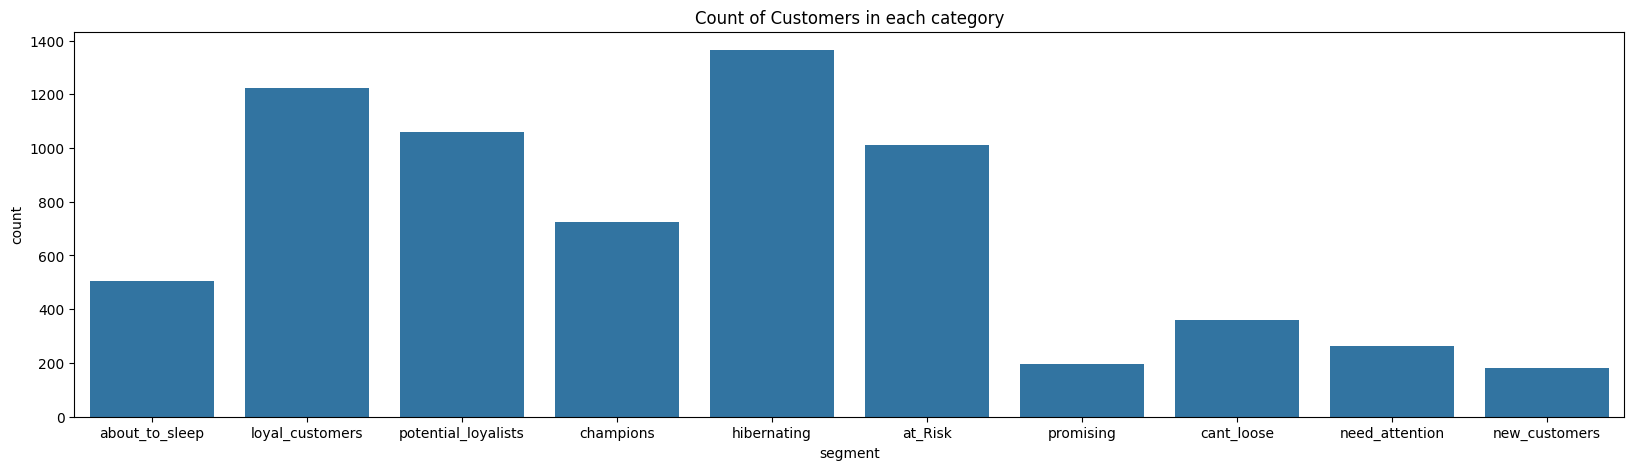

In [19]:
###visualization
''' Count of Customers in Each Category'''
plt.figure(figsize=(20,5))
sns.countplot(x='segment',data=rfm_data)
plt.title("Count of Customers in each category")
plt.show()

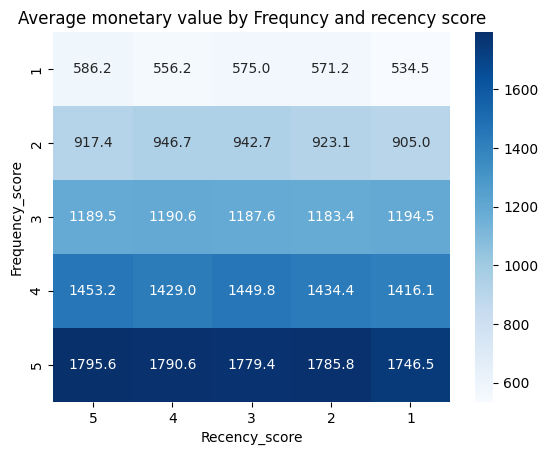

In [20]:
''' Average monetary value by Frequncy and recency score '''
sns.heatmap(pd.pivot_table(rfm_data, values = 'Monetary', index = ['Frequency_score'], columns = ['Recency_score'],
            aggfunc = np.mean), annot = True, cmap = 'Blues', fmt = '.1f')
plt.title('Average monetary value by Frequncy and recency score')
plt.show()

In [21]:
rfm_data['Recency_score'] = rfm_data['Recency_score'].astype('int')
rfm_data['Frequency_score']=rfm_data['Frequency_score'].astype('int')
rfm_data['Monetary_score']=rfm_data['Monetary_score'].astype('int')

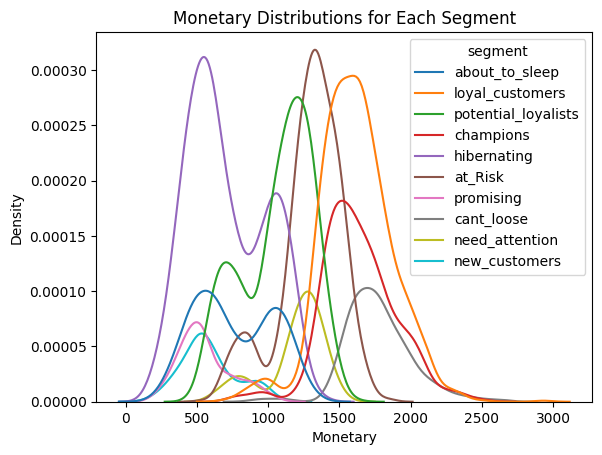

In [22]:
sns.kdeplot(x='Monetary',hue='segment',data=rfm_data)
plt.title("Monetary Distributions for Each Segment")
plt.show()


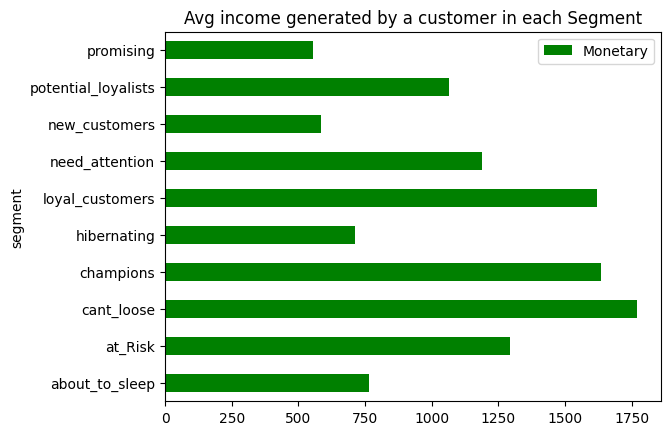

In [23]:
rfm_data.groupby('segment').agg({'Monetary':'mean'}).plot(kind='barh',color='Green')
plt.title("Avg income generated by a customer in each Segment")
plt.show()

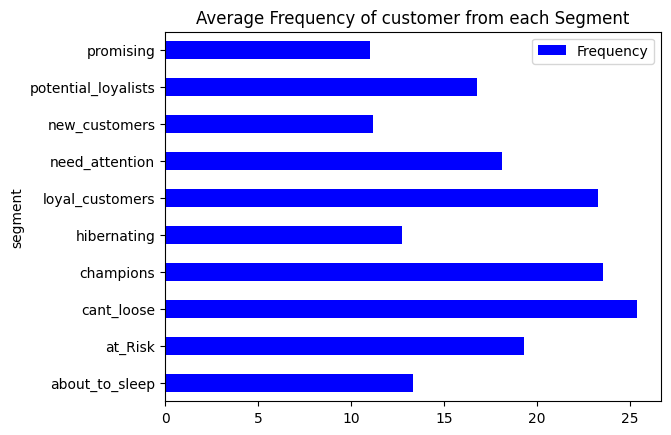

In [24]:
rfm_data.groupby('segment').agg({'Frequency':'mean'}).plot(kind='barh',color='blue')
plt.title("Average Frequency of customer from each Segment")
plt.show()